# Régression logistique avec descente de gradient et calcul parallèle

In [162]:
library(readxl)
library(ggplot2)
library(devtools)
library(formula.tools)

In [127]:
# test avec data_breast_cancer
data <- read_excel("breast.xlsx")

In [81]:
str(data)

tibble [699 x 10] (S3: tbl_df/tbl/data.frame)
 $ clump     : num [1:699] 10 4 1 2 4 1 1 5 3 1 ...
 $ ucellsize : num [1:699] 6 2 1 1 1 1 1 1 1 1 ...
 $ ucellshape: num [1:699] 6 2 1 1 1 1 1 1 1 1 ...
 $ mgadhesion: num [1:699] 2 1 1 1 1 1 1 1 1 1 ...
 $ sepics    : num [1:699] 4 2 2 2 2 2 2 2 2 2 ...
 $ bnuclei   : num [1:699] 10 1 1 1 1 1 1 1 1 4 ...
 $ bchromatin: num [1:699] 9 2 2 2 2 1 2 2 2 2 ...
 $ normnucl  : num [1:699] 7 1 1 1 1 1 1 1 1 1 ...
 $ mitoses   : num [1:699] 1 1 1 1 1 1 1 1 1 1 ...
 $ classe    : chr [1:699] "malignant" "begnin" "begnin" "begnin" ...


In [129]:
# Conversion de la variable en 0/1 à intégrer dans une fonction ? 

data$classe <- as.factor(data$classe)
levels(data$classe) <- c(0,1)
data$classe <- as.numeric(levels(data$classe))[data$classe]
#y <- matrix(ifelse(data_frame[, 1] == "malignant", 1, 0))

In [131]:
data

clump,ucellsize,ucellshape,mgadhesion,sepics,bnuclei,bchromatin,normnucl,mitoses,classe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,6,6,2,4,10,9,7,1,1
4,2,2,1,2,1,2,1,1,0
1,1,1,1,2,1,2,1,1,0
2,1,1,1,2,1,2,1,1,0
4,1,1,1,2,1,2,1,1,0
1,1,1,1,2,1,1,1,1,0
1,1,1,1,2,1,2,1,1,0
5,1,1,1,2,1,2,1,1,0
3,1,1,1,2,1,2,1,1,0


In [132]:
get_x_y <- function(formula, data) {
    data_frame <- model.frame(formula, data)

    # y <- as.factor(data_frame[, 1])
    # levels(y) <- c(1, 0)
    # y <- matrix(as.integer(y))

    
    #y <- matrix(ifelse(data_frame[, 1] == "malignant", 1, 0))

    y <- as.matrix(data_frame[, 1])


    x <- data_frame[, -1]
    x <- as.matrix(data.frame(rep(1, length(y)), x))

    return(list(target = y, features = x))
}

## Fonction sigmoide

$ \Large h(x) =  \frac{1}{1 + e^{-x} }  $  

![equation](https://latex.codecogs.com/png.latex?%5Clarge%20h%28x%29%20%3D%20%5Cfrac%7B1%7D%7B1%20&plus;%20e%5E%7B-x%7D%20%7D)

In [104]:
sigmoid <- function(x) {
    return(1 / (1 + exp(-x)))
}

## Modèle

$ \Large F(X) = X.\theta  $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20F%28X%29%20%3D%20X.%5Ctheta)

In [86]:
x_dot_theta <- function(x, theta) {
    return(x %*% theta)
}

## Fonction de la régression logistique

$ \Large h_ \theta (x) =  \frac{1}{1 + e^{- X.\theta} }  $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20h_%20%5Ctheta%20%28x%29%20%3D%20%5Cfrac%7B1%7D%7B1%20&plus;%20e%5E%7B-%20X.%5Ctheta%7D%20%7D)

In [87]:
probability <- function(x, theta) {
    return(sigmoid(x_dot_theta(x, theta)))
}

## Fonction de cout

$ \Large J(\theta) = -\frac{1}{m} \sum y \times log(\sigma(X.\theta)) + (1-y) \times (1-\sigma(X.\theta)) $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20J%28%5Ctheta%29%20%3D%20-%5Cfrac%7B1%7D%7Bm%7D%20%5Csum%20y%20%5Ctimes%20log%28%5Csigma%28X.%5Ctheta%29%29%20&plus;%20%281-y%29%20%5Ctimes%20%281-%5Csigma%28X.%5Ctheta%29%29)

In [116]:
cost_function <- function(x, y, theta) {
    m <- nrow(y)
    g <- probability(x, theta)
    j <- (1 / m) * sum((-y * log(g)) - ((1 - y) * log(1 - g)))
    return(j)
}

## Calcul du gradient

$\Large \frac{\partial J(\theta) }{\partial \theta} = \frac{1}{m} X^T.(\sigma(X.\theta)-y)$  
![equation](https://latex.codecogs.com/gif.latex?%5Cfrac%7B%5Cpartial%20J%28%5Ctheta%29%20%7D%7B%5Cpartial%20%5Ctheta%7D%20%3D%20%5Cfrac%7B1%7D%7Bm%7D%20X%5ET.%28%5Csigma%28X.%5Ctheta%29-y%29)



In [89]:
# Gradient : calcul des dérivées partielles de chacun des paramètres de theta
gradient <- function(x, y, theta) {
    m <- nrow(y)
    return((1 / m) * x_dot_theta(t(x), probability(x, theta) - y))
}

## Descente de gradient

$\Large \theta = \theta - \alpha \frac{\partial J(\theta) }{\partial \theta}$  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20%5Ctheta%20%3D%20%5Ctheta%20-%20%5Calpha%20%5Cfrac%7B%5Cpartial%20J%28%5Ctheta%29%20%7D%7B%5Cpartial%20%5Ctheta%7D)




In [105]:
batch_gradient_descent <- function(x, y, theta, learning_rate, n_iter) {
    cost_history <- c(cost_function(x, y, theta))
    m <- nrow(y)
    
    for (i in 1:n_iter) {
        # Shuffle data
        random_index <- sample(x = m, size = m)
        # Update theta
        theta <- theta - learning_rate * gradient(x[random_index, ], as.matrix(y[random_index, ]), theta)
        cost_history <- c(cost_history, cost_function(x, y, theta))
    }
    return(list(theta=theta, cost_history=cost_history))
}

In [91]:
stochastic_gradient_descent <- function(x, y, theta, learning_rate, n_iter) {
    cost_history <- c(cost_function(x, y, theta))
    m <- nrow(y)
    
    random_index <- sample(x = m, size = m)
    for (i in 1:n_iter) {
        # Shuffle data
        random_index <- sample(x = m, size = m)
        for (j in 1:m) {
            # Update theta
            y_i <- as.matrix(y[random_index[j], ])
            x_i <- t(as.matrix(x[random_index[j], ]))
            theta <- theta - learning_rate * gradient(x_i, y_i, theta)
            cost_history <- c(cost_history, cost_function(x, y, theta))
        }
    }
    return(list(theta = theta, cost_history = cost_history))
}

In [92]:
mini_batch_gradient_descent <- function(x, y, theta, learning_rate, n_iter, batch_size) {
    
    cost_history <- c(cost_function(x, y, theta))
    m <- nrow(y)
    
    for (i in 1:n_iter) {
        # Shuffle data
        random_index <- sample(x = m, size = m)
        x <- as.matrix(x[random_index, ])
        y <- as.matrix(y[random_index, ])
        x_i <- c()
        y_i <- c()

        index <- seq(1, m, batch_size - 1)

        for (j in 1:trunc(m / batch_size)) {
            y_i <- as.matrix(y[index[[j]]:index[[j + 1]], ])
            x_i <- as.matrix(x[index[[j]]:index[[j + 1]], ])
            theta <- theta - learning_rate * gradient (x_i, y_i, theta)
            cost_history <- c(cost_history, cost_function(x, y, theta))
        }

    }
    return(list(theta = theta, cost_history = cost_history))
}

In [93]:
# Gradient descent
fit <- function(formula, data, mode, batch_size, learning_rate, n_iter) {

    x_y = get_x_y(formula, data)
    x <- x_y$features
    y <- x_y$target
    
    #Création de l'instance

    initial_theta <- as.matrix(rnorm(n = dim(x)[2], mean = 0, sd = 1))
    #inst$cost_history <- c(cost_function(inst$x, inst$y, inst$theta)) # nolint
    

    if (mode == "batch" || (mode == "mini-batch" && batch_size >= nrow(y))) {
        gradient_descent <- batch_gradient_descent(x, y, initial_theta, learning_rate, n_iter) # nolint
    }else if (mode == "stochastic" || (mode == "mini-batch" && batch_size == 1)) { # nolint
        gradient_descent <- stochastic_gradient_descent(x, y, initial_theta, learning_rate, n_iter)# nolint
    }else if (mode == "mini-batch") {
        gradient_descent <- mini_batch_gradient_descent(x, y, initial_theta, learning_rate, n_iter, batch_size)# nolint
    }else{
        return("erreur")
    }


    inst <- list(formula = formula, x = x, y = y, mode = mode, batch_size = batch_size, learning_rate = learning_rate, n_iter = n_iter, theta = gradient_descent[[1]], cost_history = gradient_descent[[2]])
    attr(inst, "class") <- "Reg.Log"

    # inst <- list()
    # inst$formula <- formula
    # inst$x <- x
    # inst$y <- y
    # inst$mode <- mode
    # inst$batch_size <- batch_size
    # inst$learning_rate <- learning_rate
    # inst$n_iter <- n_iter
    # inst$theta <- gradient_descent[[1]]
    # inst$cost_history <- gradient_descent[[2]]
    return(inst)
}

In [205]:
# Surchage de la fonction print pour l'objet retourné par fit
print.Reg.Log <- function(obj) {
    cat("Model:", as.character(obj$formula), "\n")
    cat("Mode:", obj$mode, "\n")
    cat("Learning rate:", obj$learning_rate, "\n")
    cat("n_iter:",obj$n_iter, "\n")
    cat("Batch size:", obj$batch_size, "\n")
    cat("Coefficient:", obj$theta, "\n")
    cat("Cost history:", obj$cost_history)
}

In [206]:
obj.Reg.Log <- fit(classe ~ clump + ucellsize, data, mode = "batch", batch_size = 32, learning_rate = 0.1, n_iter = 4)
print(obj.Reg.Log)

Model: classe ~ clump + ucellsize 
Mode: batch 
Learning rate: 0.1 
n_iter: 4 
Batch size: 32 
Coefficient: -1.899907 0.3090346 0.113761 
Cost history: -2.15206 -1.012359 -0.09599256 0.1215669 0.1327038

In [ ]:
# Surcharge de la fonction summary pour l'objet retourné par fit 
summary.Reg.Log <- function(obj) {
    cat("Model:", as.character(obj$formula), "\n")
    cat("Mode:", obj$mode, "\n")
    cat("Learning rate:", obj$learning_rate, "\n")
    cat("n_iter:",obj$n_iter, "\n")
    cat("Batch size:", obj$batch_size, "\n")
    cat("Coefficient:", obj$theta, "\n")
    cat("Cost history:", obj$cost_history)
}

In [94]:
predict <- function(x, theta, thresold = 0.5) {
    predictions <- unlist(ifelse(probability(x, theta) > thresold, 1, 0))
    return(predictions)
}

In [156]:
res1 <- fit(classe ~ clump + ucellsize, data, mode = "batch", batch_size = 32, learning_rate = 0.1, n_iter = 1)

In [163]:
print.Reg.Log(obj.Reg.Log)

Mode: batch 
Model: 

ERROR: Error in cat("Model:", obj$formula, "\n"): argument 2 (type 'language') cannot be handled by 'cat'


In [134]:
glm(classe ~ clump + ucellsize, data = data, family = 'binomial')


Call:  glm(formula = classe ~ clump + ucellsize, family = "binomial", 
    data = data)

Coefficients:
(Intercept)        clump    ucellsize  
    -7.1517       0.6174       1.1751  

Degrees of Freedom: 698 Total (i.e. Null);  696 Residual
Null Deviance:	    900.5 
Residual Deviance: 212.3 	AIC: 218.3

                        [,1]
rep.1..length.y.. -4.8643419
clump             -0.0919829
ucellsize          1.1946776
[1] 0.8955651


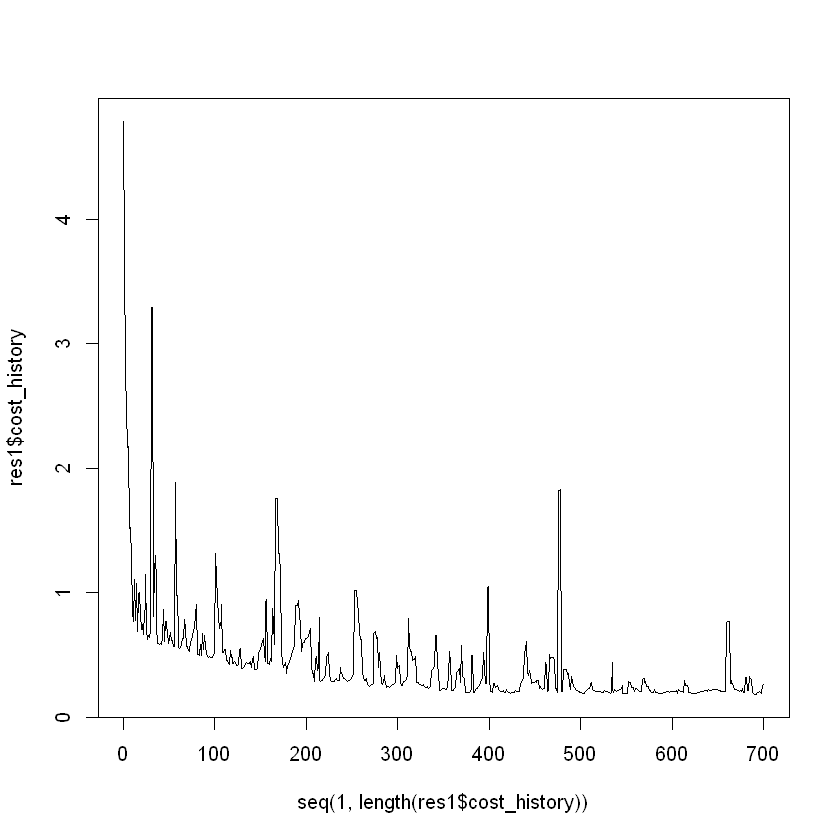

In [143]:
y_pred <- predict(res1$x, res1$theta)
plot(seq(1, length(res1$cost_history)), res1$cost_history, type = "l")

print(res1$theta)

accuracy <- mean(y_pred == res1$y)
print(accuracy)

In [ ]:
res2 <- fit(classe ~ clump + ucellsize, data, mode = "batch", batch_size = 32, learning_rate = 0.1, n_iter = 500)
y_pred <- predict(res2$x, res2$theta)
plot(seq(1, length(res2$cost_history)), res2$cost_history, type = "l")

print(res2$theta)

accuracy <- mean(y_pred == res2$y)
print(accuracy)

ERROR: Error in fit(classe ~ clump + ucellsize, data, mode = "batch", batch_size = 32, : object 'theta' not found


In [ ]:
res3 <- fit(classe ~ clump + ucellsize, data, mode = "mini-batch", batch_size = 32, learning_rate = 0.1, n_iter = 10)
y_pred <- predict(res3$x, res3$theta)
plot(seq(1, length(res3$cost_history)), res3$cost_history, type = "l")

print(res3$theta)

accuracy <- mean(y_pred == res3$y)
print(accuracy)

ERROR: Error in fit(classe ~ clump + ucellsize, data, mode = "mini-batch", batch_size = 32, : object 'theta' not found


In [ ]:
# a constructor function for the "student" class
student <- function(n,a,g) {
# we can add our own integrity checks
if(g>4 || g<0)  stop("GPA must be between 0 and 4")
value <- list(name = n, age = a, GPA = g)
# class can be set using class() or attr() function
attr(value, "class") <- "student"
value
}

In [ ]:
s <- student("Paul", 26, 3.7)
s

$name
[1] "Paul"

$age
[1] 26

$GPA
[1] 3.7

attr(,"class")
[1] "student"